# Mobile Game Depelopment project

### Task 1. 

Retention is one of the company's most important metrics. Your task is to write a function that will count the players' retention rate (by days from the registration date).

The function must be written in Python. It can be tasted either on the full dataset or a data sample.

In [3]:
#Importing all the necessary libraries 
import warnings 
warnings.filterwarnings('ignore')

import pandas as pd
import seaborn as sns
import numpy as np
import scipy.stats as ss
from scipy.stats import norm, mannwhitneyu, shapiro, chi2_contingency
from tqdm.auto import tqdm

import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
#Reading the data. There are two files: one that includes user's registration dates,
#and  the one that includes their first authorisation date. 

reg = pd.read_csv('/Users/maria/Desktop/Учеба/mnt/HC_Volume_18315164/home-jupyter/jupyter-m-ajvazjan-23/shared/problem1-reg_data.csv', sep = ';')
auth = pd.read_csv('/Users/maria/Desktop/Учеба/mnt/HC_Volume_18315164/home-jupyter/jupyter-m-ajvazjan-23/shared/problem1-auth_data.csv', sep = ';')

In [5]:
reg.head()

,reg_ts,uid
0,911382223,1
1,932683089,2
2,947802447,3
3,959523541,4
4,969103313,5


In [6]:
auth.head()

,auth_ts,uid
0,911382223,1
1,932683089,2
2,932921206,2
3,933393015,2
4,933875379,2


The dataset uses unix time. Let's convert the time to the format 'YYYY-MM-DD'.

In [7]:
reg.reg_ts = pd.to_datetime(reg.reg_ts, unit='s').dt.normalize()
auth.auth_ts = pd.to_datetime(auth.auth_ts, unit='s').dt.normalize()


In [8]:
reg.dtypes

reg_ts    datetime64[ns]
uid                int64
dtype: object

In [9]:
reg.shape

(1000000, 2)

To get the retention rate, we need to calculate the difference between users' latest authorization date and their registration date. Since the data is in different datasets, I will merge them first.

In [10]:
df = reg.merge(auth, on = 'uid', how = 'left')
df.head()

,reg_ts,uid,auth_ts
0,1998-11-18,1,1998-11-18
1,1999-07-22,2,1999-07-22
2,1999-07-22,2,1999-07-25
3,1999-07-22,2,1999-07-31
4,1999-07-22,2,1999-08-05


### A function to calculate the retention rate for each player 

In [11]:
def retention_rate(df, date):
    
    '''Creating a filter by registration date'''
    
    df = df.query("reg_ts >= @date")

    '''Creating a column with the amount of days between the registration date 
    amd the latest authorization date'''
    
    df['days'] = (df.auth_ts - df.reg_ts).dt.days
    
    '''Grouping the players by the added column''' 
    
    retention_df = df.groupby(['reg_ts','days'], as_index = False)\
                 .agg({'uid':'count'})\
                 .rename(columns={'uid': 'user_count'})\
                 .sort_values('days')
    
    '''Adding a column with the total amount of registered users'''
    
    all_players = retention_df.query('days == 0')\
                          .rename(columns={'user_count':'reg_users'})\
                          [['reg_ts', 'reg_users']]

    retention_df = retention_df.merge(all_players, on='reg_ts')\
                           .rename(columns={'reg_ts':'reg_date'})
    
    '''Calculating the retention rate by dividing the users grouped by registration date 
    by the total amount of registered users'''
    
    retention_df['rr'] = ((retention_df.user_count / retention_df.reg_users)*100).round(2)
    
    '''Visualizing the data'''
    
    retention_df = retention_df.pivot(index='reg_date', columns='days', values='rr')\
                        .drop(columns=0)\
                        .fillna('')
                        
    return retention_df

In [12]:
#Checking the function for playered registered since 2020-09-01
retention_rate(df, '2020-09-01')

days,1,2,3,4,5,6,7,8,9,10,...,13,14,15,16,17,18,19,20,21,22
reg_date,,,,,,,,,,,,,,,,,,,,,
2020-09-01,2.02,4.1,4.22,4.6,6.43,5.61,6.43,4.1,5.42,5.11,...,5.49,4.29,4.41,4.35,5.04,4.16,4.35,3.59,4.35,1.58
2020-09-02,2.52,3.9,4.66,5.67,6.23,7.12,6.3,4.85,4.09,5.67,...,4.35,4.97,5.29,4.16,4.85,3.9,3.72,4.66,2.64,
2020-09-03,2.33,5.41,4.71,6.54,6.98,8.55,6.35,5.47,6.29,6.35,...,5.97,5.47,5.34,4.4,4.84,4.65,5.47,2.39,,
2020-09-04,2.01,3.64,3.64,5.15,6.4,7.28,4.96,5.34,4.33,5.65,...,5.59,4.39,4.52,4.52,4.27,4.77,2.64,,,
2020-09-05,2.76,3.95,4.64,5.45,5.89,7.46,4.89,5.08,5.45,6.02,...,5.39,4.51,5.14,4.45,4.76,2.51,,,,
2020-09-06,3.13,4.32,5.44,5.63,5.88,6.82,6.07,5.82,5.5,4.88,...,5.19,5.5,4.57,4.82,2.56,,,,,
2020-09-07,2.94,4.25,5.37,5.06,6.37,7.31,5.25,4.12,5.62,6.0,...,5.06,4.25,5.06,3.37,,,,,,
2020-09-08,1.75,3.93,3.93,4.86,7.61,7.54,6.61,5.17,5.17,6.55,...,5.17,4.74,3.05,,,,,,,
2020-09-09,1.74,3.24,4.67,5.72,6.66,5.72,5.91,4.36,5.04,3.73,...,4.85,2.43,,,,,,,,


### Task 2. 

You have the results of an A/B test in which two groups of users were offered different promotional sets. It is known that ARPU in the test group is 5% higher than in the control group. At the same time, in the control group, 1928 players out of 202103 turned out to be paying, and in the test group - 1805 out of 202667.

What promotional set can be considered the best? What metrics should be analyzed to make the right decision and how?



In [13]:
#Reading the dataset

ab_df = pd.read_csv('/Users/maria/Desktop/Учеба/mnt/HC_Volume_18315164/home-jupyter/jupyter-m-ajvazjan-23/shared/problem2.csv', sep = ';')
ab_df

,user_id,revenue,testgroup
0,1,0,b
1,2,0,a
2,3,0,a
3,4,0,b
4,5,0,b
...,...,...,...
404765,404766,0,a
404766,404767,0,b
404767,404768,231,a
404768,404769,0,a


In [14]:
ab_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404770 entries, 0 to 404769
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   user_id    404770 non-null  int64 
 1   revenue    404770 non-null  int64 
 2   testgroup  404770 non-null  object
dtypes: int64(2), object(1)
memory usage: 9.3+ MB


In [15]:
ab_df.nunique()

user_id      404770
revenue        1477
testgroup         2
dtype: int64

In [16]:
ab_df.groupby('testgroup').describe()

user_id                                                         \
              count           mean            std  min       25%       50%   
testgroup                                                                    
a          202103.0  202555.909843  116802.329266  2.0  101502.5  202988.0   
b          202667.0  202215.564389  116891.926690  1.0  100855.5  201821.0   

                                revenue                                        \
                75%       max     count       mean         std  min  25%  50%   
testgroup                                                                       
a          303559.0  404769.0  202103.0  25.413720  920.768137  0.0  0.0  0.0   
b          303602.5  404770.0  202667.0  26.751287  287.324162  0.0  0.0  0.0   

                         
           75%      max  
testgroup                
a          0.0  37433.0  
b          0.0   4000.0

According to the data, we have two groups - control (a) and test (b) - 202103 and 202667 players in each, respectively. The total number of unique players is equal to the sum of the players in each group, which means that each observation in the dataset is unique. 

For convenience purposes, I'm going to divide the table into two separate datasets - one for each group. 

In [17]:
control_a = ab_df.query('testgroup == "a"')
test_b = ab_df.query('testgroup == "b"')

In [18]:
control_a.shape

(202103, 3)

In [19]:
test_b.shape

(202667, 3)

First metric I'm going to analyze is a convertion rate. The target action will be an in-game purchase. To calculate the convertion into a purchase I will divide users into customers and buyers and calculate their ratio.

In [20]:
control_a['player_type'] = control_a.revenue.apply(lambda x: 'purchaser' if x > 0 else 'user')
test_b['player_type'] = test_b.revenue.apply(lambda x: 'purchaser' if x > 0 else 'user')

In [21]:
#Counting the convertion rate for the control group 
control_a.player_type.value_counts(normalize=True) * 100 

user         99.046031
purchaser     0.953969
Name: player_type, dtype: float64

In [22]:
#Counting the convertion rate for the test group 
test_b.player_type.value_counts(normalize=True) * 100 

user         99.109376
purchaser     0.890624
Name: player_type, dtype: float64

The results show that the conversion in the control group is higher and is 0.95%, while the conversion in the test group is 0.89%.

Next, let's look at the check distribution in each of the groups.

<AxesSubplot: >

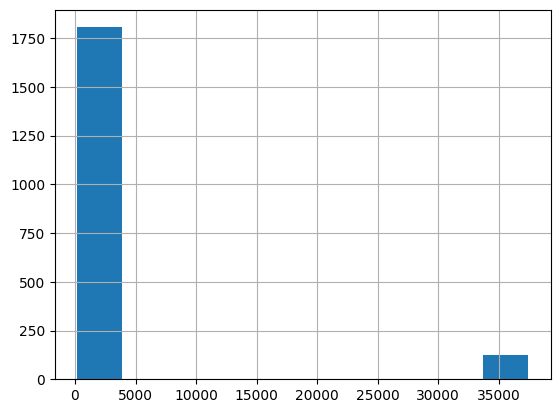

In [23]:
control_a.query('player_type == "purchaser"').revenue.hist()

In [24]:
control_a.query('player_type == "purchaser"').revenue.describe()

count     1928.000000
mean      2663.998444
std       9049.039763
min        200.000000
25%        257.000000
50%        311.000000
75%        361.000000
max      37433.000000
Name: revenue, dtype: float64

<AxesSubplot: >

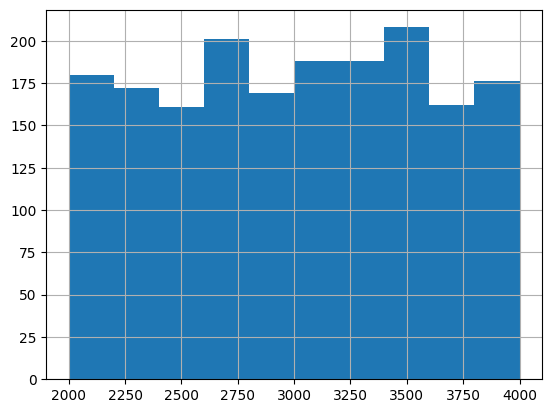

In [25]:
test_b.query('player_type == "purchaser"').revenue.hist()

In [26]:
test_b.query('player_type == "purchaser"').revenue.describe()

count    1805.000000
mean     3003.658172
std       572.619709
min      2000.000000
25%      2513.000000
50%      3022.000000
75%      3478.000000
max      4000.000000
Name: revenue, dtype: float64

We see that checks in the test group are distributed evenly, while in the control group there's a big gap between the lowest and the highest check. We also see that some players made a purchase for more than 30 000 in total. 
Let's look at the check distribution in the control group without these large payments. 

In [27]:
control_a.query('player_type == "purchaser" and revenue < 30000').revenue.describe()

count    1805.000000
mean      302.458172
std        57.914246
min       200.000000
25%       254.000000
50%       305.000000
75%       352.000000
max       400.000000
Name: revenue, dtype: float64

<AxesSubplot: >

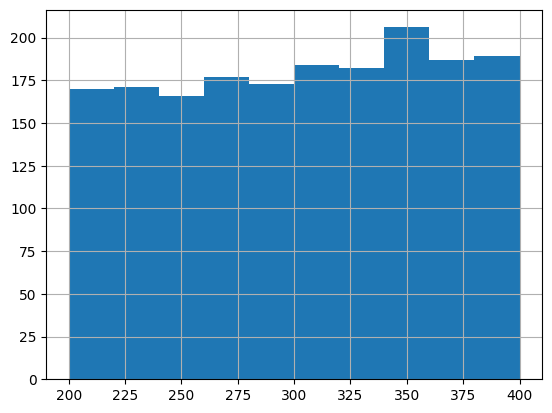

In [28]:
control_a.query('player_type == "purchaser" and revenue < 30000').revenue.hist()

According to the histogram, if we exclude large payments for over 30 000, we see even check distribution in the control group. 

Let's take a look at the total revenue in both groups. 

In [29]:
print('Total revenue in the control group:', control_a.revenue.sum(),'\n',
      'Total revenue in the test group:', test_b.revenue.sum())

Total revenue in the control group: 5136189 
 Total revenue in the test group: 5421603


In [30]:
#Calculating what persentage of the revenue comes from the premium users
premium_payers = ((control_a.query('player_type == "purchaser" and revenue > 30000').revenue.sum() / control_a.revenue.sum())*100).round(2)
premium_payers

89.37

In [31]:
#Calculating the share of premium clients of the total amount of players in the group 
premium_players = ((control_a.query('player_type == "purchaser" and revenue > 30000').user_id.count() / control_a.user_id.count())*100).round(2)
premium_players

0.06

We see that most of the revenue (89.37%) in the control group is generated by premium payers, whose share of the total users of the group is only 0.06%.

Moving on to calculating two more metrics - ARPPU (average revenue per paying user) and ARPU (average revenue per user).

In [32]:
#Test group 
test_arppu = (test_b.revenue.sum() / test_b.query('player_type == "purchaser"').shape[0]).round(2)
test_arpu = (test_b.revenue.sum()/ test_b.shape[0]).round(2)

In [33]:
#Control group
control_arppu = (control_a.revenue.sum() / control_a.query('player_type == "purchaser"').shape[0]).round(2)
control_arpu = (control_a.revenue.sum()/ control_a.shape[0]).round(2)

In [34]:
print('ARPPU of the test group:', test_arppu,'\n',
      'ARPPU of the control group:', control_arppu,'\n',
      'ARPU of the test group:', test_arpu,'\n',
      'ARPU of the control group:', control_arpu,'\n')

ARPPU of the test group: 3003.66 
 ARPPU of the control group: 2664.0 
 ARPU of the test group: 26.75 
 ARPU of the control group: 25.41 



Values of both metrics are higher in the test group. However, testing is required to check if the differences are random or significant, i. e. determined by the implemented promotional offer. To do this, I'm going to use statistical methods. To decide which statistical tests to select, I will first use the Shapiro–Wilk normality test to check if the data is distributed normally. 

We'll start with ARPU. 

In [35]:
print(ss.shapiro(test_b.revenue))
print(ss.shapiro(control_a.revenue))

ShapiroResult(statistic=0.06588172912597656, pvalue=0.0)
ShapiroResult(statistic=0.008876502513885498, pvalue=0.0)


The resulting p-value shows that we have an abnormal distribution in both groups. We will next test the equality of means. For this, I'm going to use bootstrapping as the main method here. 

The hypotheses to test:\
H0 - differences are random and not statistically significant\
H1 - differences are statistically significant

In [36]:
# Creating a function which will test the hypotheses using bootstrap 
def get_bootstrap(
    control, # values for the first sample 
    test, # values for the second sample
    boot_it = 1000, # number of bootstrap subsamples
    statistic = np.mean, # statistics we test
    bootstrap_conf_level = 0.95 # significance level
):
    boot_len = max([len(control), len(test)])
    boot_data = []
    for i in tqdm(range(boot_it)): # extracting subsamples
        samples_1 = control.sample(
            boot_len, 
            replace = True # return parameter
        ).values
        
        samples_2 = test.sample(
            boot_len, 
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1-samples_2)) 
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    ci = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Visualizing
    plt.hist(pd_boot_data[0], bins = 50)
    
    plt.style.use('ggplot')
    plt.vlines(ci,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "ci": ci, 
            "p_value": p_value}

100%|██████████| 2000/2000 [00:40<00:00, 49.65it/s]


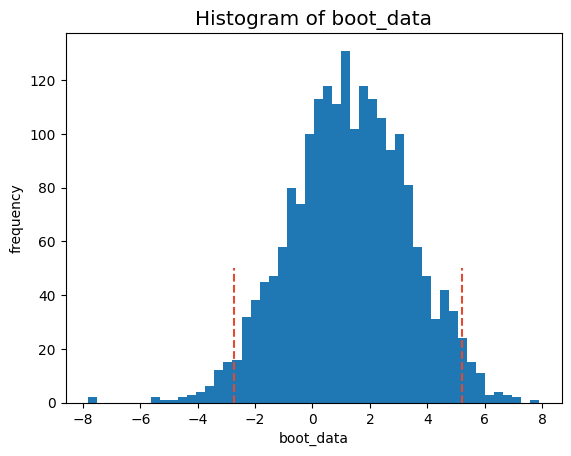

In [37]:
# the result contains the difference between two distributions, CI and p-value
booted_data = get_bootstrap(test_b.revenue, control_a.revenue, boot_it = 2000) 

In [38]:
print(booted_data["p_value"])
print(booted_data["ci"])

0.5326165632831759
              0
0.025 -2.723702
0.975  5.210019



We found that p-value > 0.05, which means that there's not currently enough evidence to conclude that the null hypothesis can be rejected and leads to the conclusion that the differences presented in the two groups are not statistically significant.

Therefore, the difference in ARPU in the two groups is random.

Similarly, we will check the next metric - ARPPU. We'll start by testing the normality of distribution.

In [39]:
x = control_a.query('revenue > 0')
y = test_b.query('revenue > 0')
print(ss.shapiro(x.revenue))
print(ss.shapiro(y.revenue))

ShapiroResult(statistic=0.2667924165725708, pvalue=0.0)
ShapiroResult(statistic=0.9583134651184082, pvalue=2.4929213770979496e-22)


100%|██████████| 2000/2000 [00:00<00:00, 3004.37it/s]


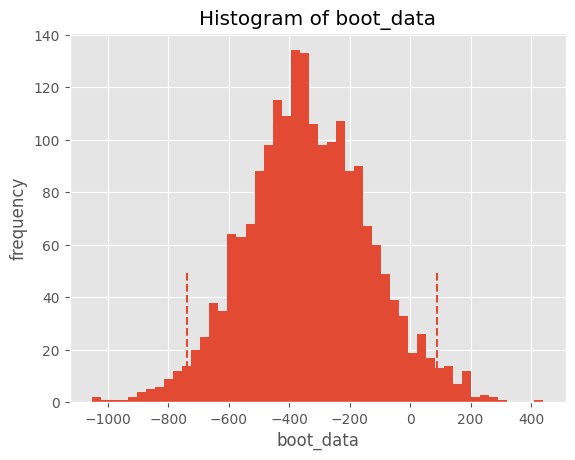

In [40]:
booted_data_2 = get_bootstrap(x.revenue, y.revenue, boot_it = 2000)

In [41]:
print(booted_data_2["p_value"])
print(booted_data_2["ci"])

0.10255396166443269
                0
0.025 -736.928060
0.975   87.615301


In this case, the p-value is also greater than 0.05, and a confidence interval includes zero. This also leads to the retention of the null hypothesis and gives us a reason to claim that the differences in the ARPPU metric are also not statistically significant.

Previously, we calculated the conversion rate and found the difference in CR between the test and control groups, which was that the CR in the control group was higher. However, it is also necessary to check if these differences are statistically significant.


In [42]:
ab_df['player_type'] = ab_df.revenue.apply(lambda x: 'purchaser' if x > 0 else 'user')

In [43]:
pd.crosstab(ab_df.player_type, ab_df.testgroup) 

testgroup,a,b
player_type,,
purchaser,1928,1805
user,200175,200862


In [44]:
stat, p, dof, expected = chi2_contingency(pd.crosstab(ab_df.player_type, ab_df.testgroup)) 

print("P-value =",             p.round(3), '\n', 
      "Chi2 =",                stat.round(3),'\n', 
      "Degrees of Freedom =",  dof,'\n',
      "Expected Values =",     expected.round())

P-value = 0.036 
 Chi2 = 4.375 
 Degrees of Freedom = 1 
 Expected Values = [[  1864.   1869.]
 [200239. 200798.]]


Here we got the opposite result - the p-value allows us to reject the null hypothesis and confirm that the changes are statistically significant.

Conclusions

In this project, we analyzed three main metrics - CR, ARPU, and ARPPU. The CR in the control group was higher, and further tests confirmed that these differences are statistically significant. However, total revenue was higher in the test group.

The other two metrics - ARPU and ARPPU - turned out to be higher in the test group. However, the bootstrap showed that we can assume, with a high degree of probability, that these differences are random and not determined by the implemented promotional offer.

We also looked at the check distribution in both groups and found that in the test group the distribution is even and ranges between 2000-4000 USD. Meanwhile, in the control group, we can see a small group of premium players with large in-game purchases for over 30,000 USD, having the checks of other players of the same group range between 200-400 USD. 89.37% of the income in the control group is generated by premium players, while their share is only 0.06% of total users in the group.

At first glance, promotional offer sets in the test group look more attractive. With a lower CR, the total revenue, as well as the average check, is higher in the group, and the check distribution is more even, hence more stable.
However, testing of other metrics showed that the metric changes in the test group are not determined by the promotional offer sets but are random.

Therefore, I suggest that we continue testing promotional offer sets and observing user behavior for a longer period and not roll out the features to all users yet.

### Task 3.

Plants & Gardens game has a limited-time themed event every month. In these events, players can get unique items for their virtual garden and the characters, as well as additional coins or bonuses. To receive a reward, you need to complete a series of levels in a certain amount of time. 
What metrics can be used to evaluate the results of the latest themed event?

Suppose that in another event, we made it harder for players to succeed in the event. Now, with each unsuccessful attempt to complete the level, the player will roll back several levels. Will the set of performance evaluation metrics change? If so, how?

##### Metrics for evaluating the results of a themed event: 

- To count the number of players who participated in the themed event.  **Active users** metric allows calculating how many players used the application at the time of the event.\
Metrics **DAU - the number of active users per day, and MAU - he number of active users per month** could be suitable for this, depending on the duration of the event. We can later compare the results with the ones we had during the pre-event period. 
- It would also be useful to check the **Stickness rate** - the percentage of users who "stick" to the application. Stickiness rate = DAU/MAU
- **Retention rate** - the percentage of users who logged into the application over a certain period after the first login. Increased RR is one of the indicators of the success of the event.
- The retention rate is closely related to the user **Churn rate**. This metric should become lower. If it does not happen, it is necessary to analyze at what stage most users fall off, whether it is due to technical errors or to the difficulties that players face in the game itself (for example, the complexity of the level).
In this case, we can analyze each level of the game and find out the average time players take to complete each level and to complete all the levels.
- **Lifetime** - a metric that evaluates the time spent in the game and indicates the involvement of users in the game.
- Interest in the event can also be evaluated using the **Conversion rate** - both the conversion of all players into users participating in the event and the conversion funnel that leads them through passing each level.

##### Monetary metrics
If the game provides in-app purchases, it would also be useful to pay attention to the following metrics:
- **New Paying Users** - the number of users who made their first payment in the application during the event.
- **Conversion Rate** - in this case, we will use the payment as a target action and count the users who have converted into buyers.
- **ARPU** - average income per user.
- **ARPPU** - average income per paying user.
We are looking to see if the metrics  changed with the start of the event and decide if the event is successful in terms of revenue.

##### Will the set of performance evaluation metrics change with the modifications in the game rules? If so, how?

The metrics above will remain relevant.\
Closer attention, in this case, will need to be paid to the relative conversion of moving to the next level and to the retention rate: what share of players remain in the game even after rollbacks to previous levels.\

It will also be useful to study monetary metrics here. If there is an option in the game to buy additional bonuses to move to the next level faster, then it is likely that this will motivate players to pay more. This will directly affect monetary metrics (first of all, ARPU, ARPPU), which show us if the event is a success in terms of revenue.

As an additional metric, we should also look at the ASL - average session duration - and see if it has changed after the modifications. Perhaps the average session time has become shorter as users get tired of replaying levels.

It can be informative to study all the metrics by user segments (grouped by the number of levels passed, bonuses earned, etc.)